## Final Project Submission¶

Student name: Eduardo Osorio

Student pace: part time 

Scheduled project review date/time:

Instructor name: Yish Lim

Blog post URL:

## Log transform and dummy variables
- We log transformed to make the data less skewed

- created dummy variables before running train-test split

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

kcc = pd.read_csv('data_files/kc_cleaned.csv')

continuous = ['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'yr_built']
categoricals = ['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month']

kcc_cont = kcc[continuous]

# log features
log_names = [f'{column}_log' for column in kcc_cont.columns]

kcc_log = np.log(kcc_cont)
kcc_log.columns = log_names

# normalize (subract mean and divide by std)

# def normalize(feature):b
#     return (feature - feature.mean()) / feature.std()

# kcc_log_norm = kcc_log.apply(normalize)

# one hot encode categoricals
kcc_ohe = pd.get_dummies(kcc[categoricals], columns=['bedrooms', 'floors', 'waterfront', 'grade', 'condition', 'yrs_renovated', 'sale_month'], drop_first=True)

preprocessed = pd.concat([kcc_log, kcc_ohe], axis=1)

In [3]:
preprocessed

,price_log,sqft_living_log,sqft_lot_log,sqft_living15_log,yr_built_log,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,...,sale_month_3,sale_month_4,sale_month_5,sale_month_6,sale_month_7,sale_month_8,sale_month_9,sale_month_10,sale_month_11,sale_month_12
0,13.195614,7.851661,8.887653,7.432484,7.576097,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,12.100712,6.646391,9.210340,7.908387,7.566828,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13.311329,7.580700,8.517193,7.215240,7.583248,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,13.142166,7.426549,8.997147,7.495542,7.594381,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.022525,8.597851,11.532042,8.468003,7.601402,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19211,13.071070,7.177782,7.165493,7.192934,7.604894,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19212,12.793859,7.333023,7.030857,7.333023,7.605392,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
19213,12.899220,7.745003,8.667852,7.512071,7.607878,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
19214,12.904459,6.927558,7.207860,6.927558,7.605392,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Stepwise Function
- using a stwepwise funtion with backwards elimination to drop p-values over .05

In [4]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, # Pvals over .05 are dropped
                       verbose=True):
 
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) #Adding pvals under the threshold

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval)) #drops pvals over thershold
        if not changed:
            break
    return included

## Train-Test Split
- Using train test split to make sample size of 20 % 

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X = preprocessed.drop('price_log', axis=1)
y = preprocessed['price_log']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# Using a test size of 20%

## Running the stepwise
- Ran the stepwise function on the X_train and y_train  to eliminate p-values over .05

In [8]:
result = stepwise_selection(X_train, y_train, verbose = True)
print('resulting features:')
print(result)
#Feed x_train and Y_train into the stepwise function

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Add  grade_6                        with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  yr_built_log                   with p-value 2.96781e-208
Add  grade_7                        with p-value 0.0
Add  grade_8                        with p-value 5.35003e-204
Add  grade_5                        with p-value 1.0747e-221
Add  grade_9                        with p-value 9.0687e-107
Add  waterfront_1.0                 with p-value 1.59362e-88
Add  sqft_lot_log                   with p-value 1.82427e-88
Add  sqft_living15_log              with p-value 2.74133e-88
Add  grade_4                        with p-value 4.15822e-59
Add  floors_3.0                     with p-value 2.42517e-44
Add  bedrooms_2                     with p-value 4.78185e-40
Add  grade_10                       with p-value 6.68903e-33
Add  condition_5                    with p-value 3.45083e-21
Add  sale_month_4                   with p-value 1.65251e-12
Add  grade_11                       with p-val

C:\Users\eduar\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  yrs_renovated_10.0             with p-value 0.00196191
Add  yrs_renovated_13.0             with p-value 0.00242439
Add  yrs_renovated_6.0              with p-value 0.00365325
Add  floors_2.5                     with p-value 0.00565418
Add  floors_1.5                     with p-value 0.00306982
Add  yrs_renovated_14.0             with p-value 0.00956628
resulting features:
['grade_6', 'sqft_living_log', 'yr_built_log', 'grade_7', 'grade_8', 'grade_5', 'grade_9', 'waterfront_1.0', 'sqft_lot_log', 'sqft_living15_log', 'grade_4', 'floors_3.0', 'bedrooms_2', 'grade_10', 'condition_5', 'sale_month_4', 'grade_11', 'sale_month_3', 'bedrooms_4', 'floors_2.0', 'condition_4', 'condition_3', 'yrs_renovated_10.0', 'yrs_renovated_13.0', 'yrs_renovated_6.0', 'floors_2.5', 'floors_1.5', 'yrs_renovated_14.0']


## OLS

In [9]:
X_fin = X_train[result]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y_train,X_with_intercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     1059.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        12:42:10   Log-Likelihood:                -3662.6
No. Observations:               15372   AIC:                             7383.
Df Residuals:                   15343   BIC:                             7605.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 88.4239      1.804     49.005      0.000      84.887      91.961
grade_6               -1.3173      0.041    -32.447      0.000      -1.397      -1.238
sqft_living_log        0.4428      0.011     39.109      0.000       0.421       0.465
yr_built_log         -10.4763      0.238    -44.036      0.000     -10.943     -10.010
grade_7               -1.1022      0.039    -28.390      0.000      -1.178      -1.026
grade_8               -0.8999      0.038    -23.632      0.000      -0.975      -0.825
grade_5               -1.4680      0.047    -31.188      0.000      -1.560      -1.376
grade_9               -0.6589      0.038    -17.406      0.000      -0.733      -0.585
waterfront_1.0         0.5499      0.028     19.327      0.000       0.494       0.606
sqft_lot_log          -0.0568      0.003    -17.052      0.000      -0.063      -0.050
sqft_living15_log      0.2707      0.013     21.619      0.000       0.246       0.295
grade_4               -1.4711      0.078    -18.930      0.000      -1.623      -1.319
floors_3.0             0.2488      0.017     14.341      0.000       0.215       0.283
bedrooms_2             0.1105      0.009     12.906      0.000       0.094       0.127
grade_10              -0.4532      0.038    -11.813      0.000      -0.528      -0.378
condition_5            0.2383      0.028      8.549      0.000       0.184       0.293
sale_month_4           0.0644      0.008      7.877      0.000       0.048       0.080
grade_11              -0.2669      0.041     -6.502      0.000      -0.347      -0.186
sale_month_3           0.0466      0.009      5.222      0.000       0.029       0.064
bedrooms_4            -0.0302      0.006     -5.120      0.000      -0.042      -0.019
floors_2.0             0.0321      0.007      4.473      0.000       0.018       0.046
condition_4            0.1552      0.027      5.798      0.000       0.103       0.208
condition_3            0.1305      0.027      4.890      0.000       0.078       0.183
yrs_renovated_10.0     0.2657      0.082      3.227      0.001       0.104       0.427
yrs_renovated_13.0     0.2016      0.067      2.994      0.003       0.070       0.334
yrs_renovated_6.0      0.1243      0.042      2.974      0.003       0.042       0.206
floors_2.5             0.0868      0.029      3.012      0.003       0.030       0.143
floors_1.5             0.0293      0.010      2.999      0.003       0.010       0.049
yrs_renovated_14.0     0.1997      0.077      2.591      0.010       0.049       0.351
==============================================================================
Omnibus:                       41.777   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.788
Skew:                          -0.090   Prob(JB):             

## Recursive Feature Elimination
- Using skitlearns REF algorithm to select the most relevant features fo us
- in this case, were using all the future since our r squared is lower then what I wanted

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 46)
selector = selector.fit(X_fin, y_train.values.ravel()) 
selector.support_ 

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [11]:
selected_columns = X_fin.columns[selector.support_ ]
linreg.fit(X_train[selected_columns],y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
selected_columns

Index(['grade_6', 'sqft_living_log', 'yr_built_log', 'grade_7', 'grade_8',
       'grade_5', 'grade_9', 'waterfront_1.0', 'sqft_lot_log',
       'sqft_living15_log', 'grade_4', 'floors_3.0', 'bedrooms_2', 'grade_10',
       'condition_5', 'sale_month_4', 'grade_11', 'sale_month_3', 'bedrooms_4',
       'floors_2.0', 'condition_4', 'condition_3', 'yrs_renovated_10.0',
       'yrs_renovated_13.0', 'yrs_renovated_6.0', 'floors_2.5', 'floors_1.5',
       'yrs_renovated_14.0'],
      dtype='object')

## R Squared and MSE
- Here are is the R squared and Mean Squared error for both the Test and Train

In [13]:
y_hat_train = linreg.predict(X_fin[selected_columns])
y_hat_test = linreg.predict(X_test[selected_columns])

In [14]:
linreg.score(X_fin[selected_columns], y_train)

0.6589153088230563

## Un-Logging
- Since we log transformed at the begining we also need to un-log to get an accurate standard error

In [15]:
mse_train = np.sum((np.exp(y_train)-np.exp(y_hat_train))**2)/len(y_train)
mse_test = np.sum((np.exp(y_test)-np.exp(y_hat_test))**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 41460573931.575516
Test Mean Squarred Error: 49072900149.4901


In [17]:
train_error= np.sqrt(mse_train)
test_error = np.sqrt(mse_test)
print(train_error)
print(test_error)

203618.69740172566
221524.03966497653


## Checking  the QQ plot and Homoscedasticity
- 

In [19]:
import scipy.stats as stats

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

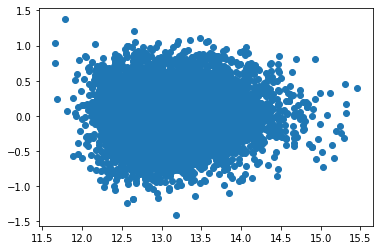

In [21]:
plt.scatter(y_hat_train, model.resid)
# plt.plot(y_hat_train(X_train[selected_columns])

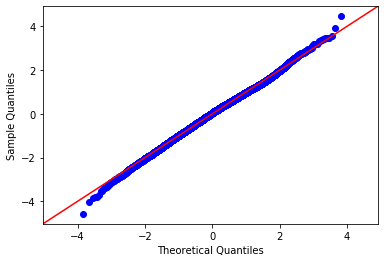

In [22]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

## Testing for Multicollinearity

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = X_fin
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
list(zip(X_fin, vif))

[('grade_6', 8.704348847986752),
 ('grade_10', 6.791008644835644),
 ('grade_7', 37.13121667556937),
 ('sqft_living15_log', 1459.0374730924532),
 ('sqft_living_log', 1170.5942501328332),
 ('yr_built_log', 1374.8979770655476),
 ('grade_11', 3.3804830271210027),
 ('sqft_lot_log', 147.12898252613314),
 ('grade_9', 13.272958103121738),
 ('grade_12', 1.5787590318343774),
 ('waterfront_1.0', 1.0443366692384843),
 ('floors_3.0', 1.29425910125208),
 ('bedrooms_2', 1.5118524484818638),
 ('grade_13', 1.0868508214816257),
 ('condition_5', 1.204538537250771),
 ('grade_8', 27.20618664121825),
 ('sale_month_4', 1.1318417502648668),
 ('condition_2', 1.0338355947051383),
 ('sale_month_3', 1.1090988627073388),
 ('bedrooms_4', 1.803306375400854),
 ('floors_2.0', 2.800796493509994),
 ('yrs_renovated_66.0', 1.0010829036438262),
 ('yrs_renovated_13.0', 1.0041107970395684),
 ('condition_4', 1.5789903389248277),
 ('yrs_renovated_10.0', 1.0018616473836257),
 ('floors_1.5', 1.218139627521191),
 ('yrs_renovated_

- Some of the features are displaying multicollinearity but droping them would lower the r squared even lower then it already is.